Adapted from [PyTorch DQN tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) (link last checked on March 19th 2024)).

In [1]:
from collections import namedtuple, deque
from itertools import count
import math
import matplotlib.pyplot as plt
import neptune
import random
from tqdm.notebook import tqdm
import yaml

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
%matplotlib widget

In [3]:
%load_ext autoreload
%autoreload 2
from Environment import Environment

In [4]:
env = Environment(seed=23)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Replay Memory

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN

## Model

In [6]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, n_actions)

    # Predicts the reward of each combination of state and action
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Setup

In [7]:
BATCH_SIZE = 128
GAMMA = 0.99     # discount factor
EPS_START = 0.9  # starting value of epsilon
EPS_END = 0.05   # final value of epsilon
EPS_DECAY = 1000 # controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 1e-3       # update rate of the target network
LR = 25e-5

# Get number of actions (P)
n_actions = env.n_actions
# Get the number of state observations
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.sample()]], device=device, dtype=torch.long)

In [8]:
# load neptune api key
with open('.neptune_config.yaml', 'r') as config_file:
    neptune_config = yaml.safe_load(config_file)
api_token = neptune_config.get('api_token')
# init neptune
run = neptune.init_run(
    project='chacungu/ECO4AI-Reinforcement-Learning', 
    api_token=api_token, 
    tags=['reds'],
    capture_stdout=False,
    capture_stderr=False,
    capture_traceback=False,
    capture_hardware_metrics=False,
)
run['parameters'] = {
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'EPS_START': EPS_START,
    'EPS_END': EPS_END,
    'EPS_DECAY': EPS_DECAY,
    'TAU': TAU,
    'LR': LR,
}

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/chacungu/ECO4AI-Reinforcement-Learning/e/ECO4AIRL-14


In [9]:
def plot_durations(episode_durations):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Result')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

## Training loop

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [12]:
num_episodes = 1e5
terminated_ctr = 0
episode_durations = []

for i_episode in tqdm(range(int(num_episodes))):
    # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
                
        terminated_ctr += 1
        run['train/action'].log(action.item())

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            break

    run['train/episode_durations'].log(episode_durations[-1])
    run['train/terminated_ctr'].log(terminated_ctr)

print('Complete')

  0%|          | 0/100000 [00:00<?, ?it/s]

Complete


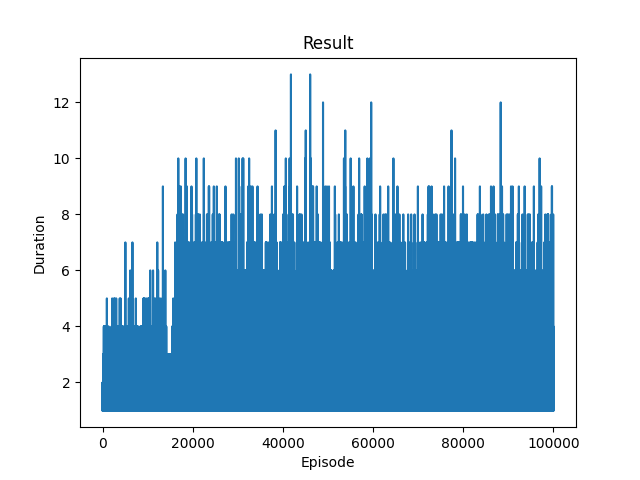

In [13]:
plot_durations(episode_durations)

In [ ]:
import pandas as pd

episode = env.history[7]

delays = pd.DataFrame(columns=list(range(len(episode))), 
                      index=pd.MultiIndex.from_product([
                           list(range(env.n_actions)), 
                           ['front', 'wifi', 'back']
                          ], names=['action', 'delay']))
actions = []
for t, hist in enumerate(episode):
    actions.append(hist.action)
    for p in range(env.n_actions):
        delays.at[(p, 'front'), t] = hist.front_delays[p]
        delays.at[(p, 'wifi'), t] = hist.transmission_delays[p]
        delays.at[(p, 'back'), t] = hist.back_delays[p]

In [15]:
delays

0
action delay            
0      front         0.0
       wifi   192.060678
       back   -51.299218
1      front   51.937782
       wifi   188.854695
       back      4.03089
2      front   81.596666
       wifi   227.953032
       back    68.100241
3      front  106.184432
       wifi    99.407603
       back    56.883848
4      front  133.282541
       wifi   182.116257
       back     8.663751
5      front  159.182782
       wifi    38.426326
       back     2.456882
6      front  185.691977
       wifi   156.098018
       back     0.899603
7      front  215.307106
       wifi       0.0022
       back     0.283012
8      front  240.986905
       wifi          0.0
       back          0.0

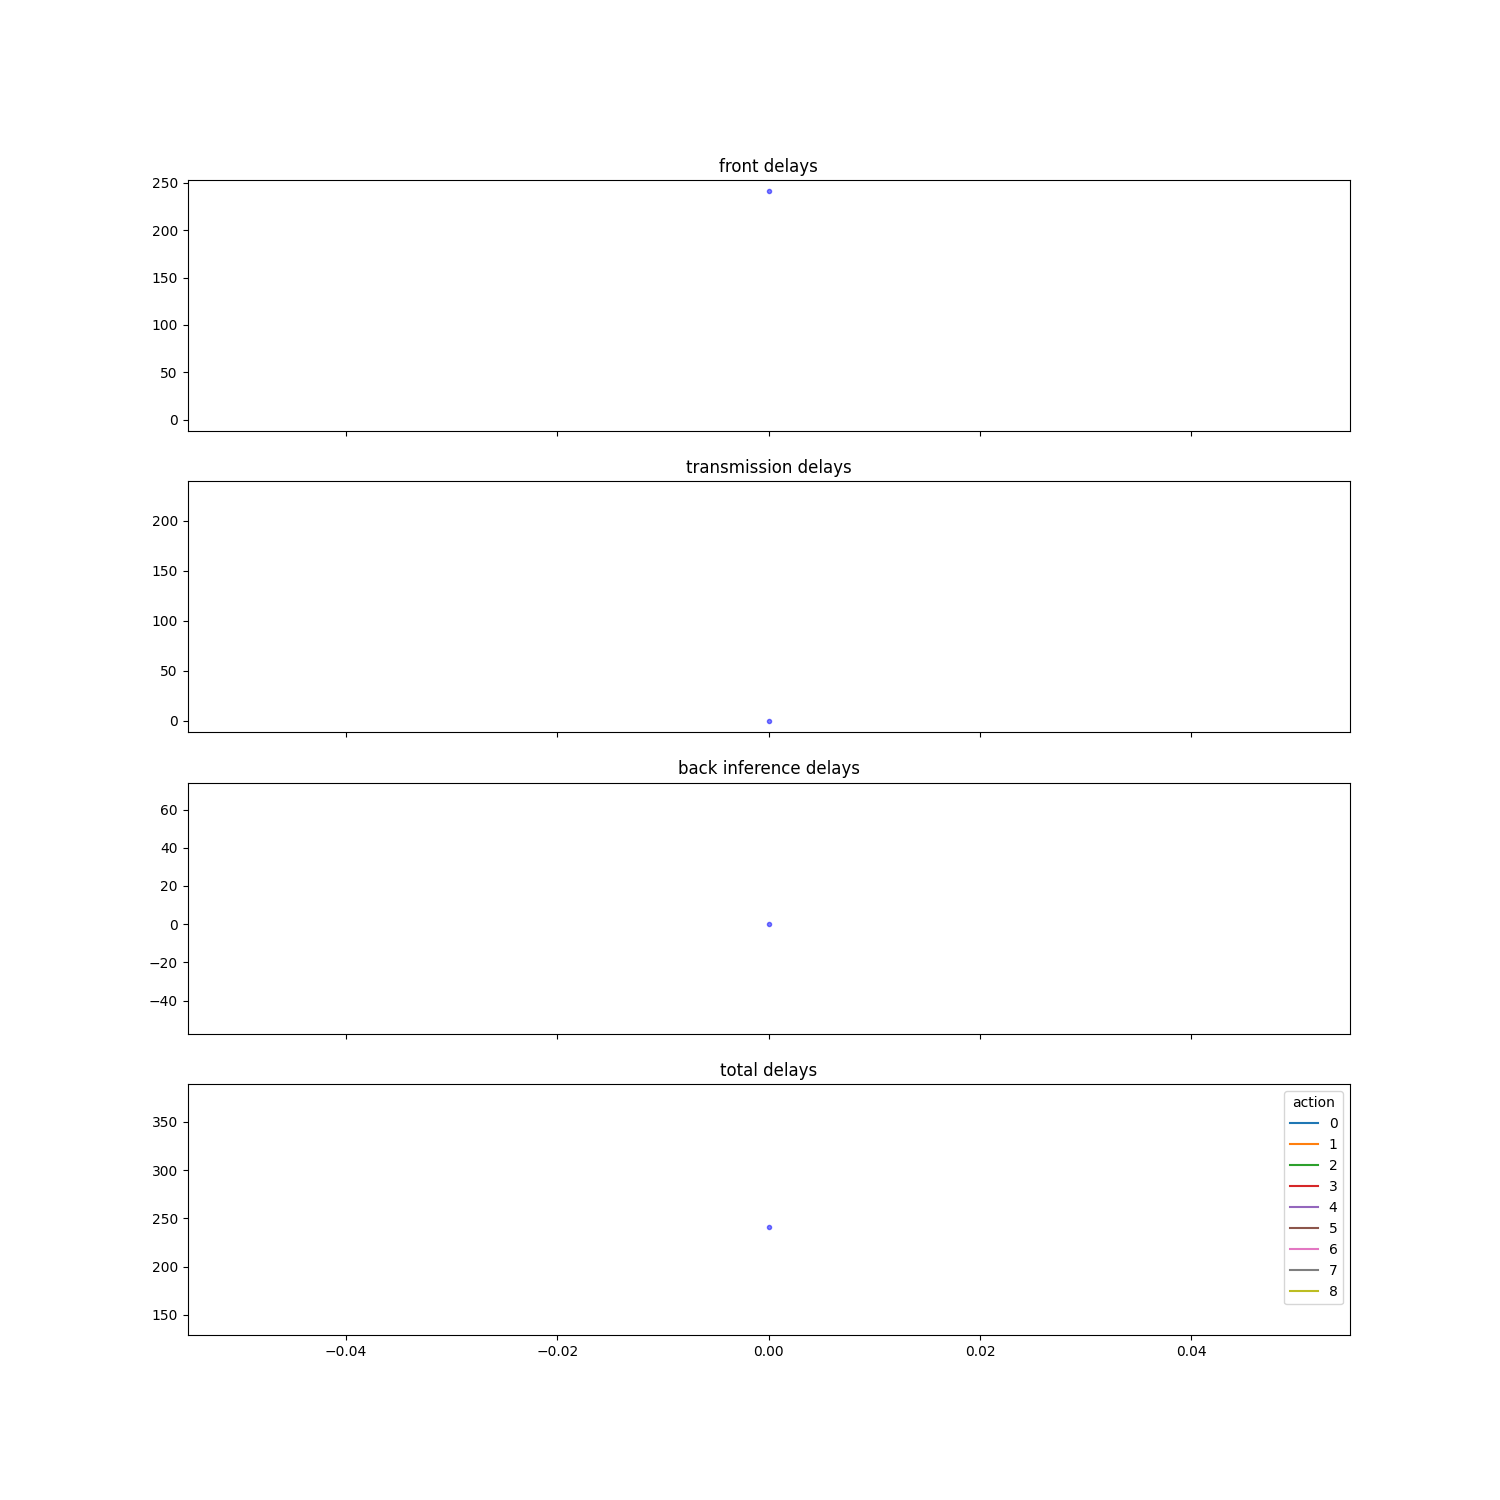

In [16]:
fig, axes = plt.subplots(4, figsize=(15, 15))

delays_ = delays.loc[(slice(None), 'front'), :].droplevel(1)
delays_.T.plot(title='front delays', ax=axes[0], sharex=True, legend=False)
axes[0].plot([delays_.loc[action.cpu().item(), t] for t in delays_.columns], 'bo', markersize=3, alpha=0.5)

delays_ = delays.loc[(slice(None), 'wifi'), :].droplevel(1)
delays_.T.plot(title='transmission delays', ax=axes[1], sharex=True, legend=False)
axes[1].plot([delays_.loc[action.cpu().item(), t] for t in delays_.columns], 'bo', markersize=3, alpha=0.5)

delays_ = delays.loc[(slice(None), 'back'), :].droplevel(1)
delays_.T.plot(title='back inference delays', ax=axes[2], sharex=True, legend=False)
axes[2].plot([delays_.loc[action.cpu().item(), t] for t in delays_.columns], 'bo', markersize=3, alpha=0.5)

delays_ = delays.groupby(level=[0]).sum()
delays_.T.plot(title='total delays', ax=axes[3], sharex=True, legend=True)
axes[3].plot([delays_.loc[action.cpu().item(), t] for t in delays_.columns], 'bo', markersize=3, alpha=0.5)

# Distributions

In [44]:
def plot_distrib(mu, sigma, color, p):
    plt.hist(
        np.random.normal(mu, sigma), 
        bins=50, density=True, alpha=0.7, color=color, edgecolor='black', label=f'transmission {p}'
    )
    xmin, xmax = plt.xlim(0, 300)
    x = np.linspace(xmin, xmax, 100)
    p = np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    plt.plot(x, p, color, linewidth=2)

/tmp/ipykernel_778/2368742021.py:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  xmin, xmax = plt.xlim(0, 300)


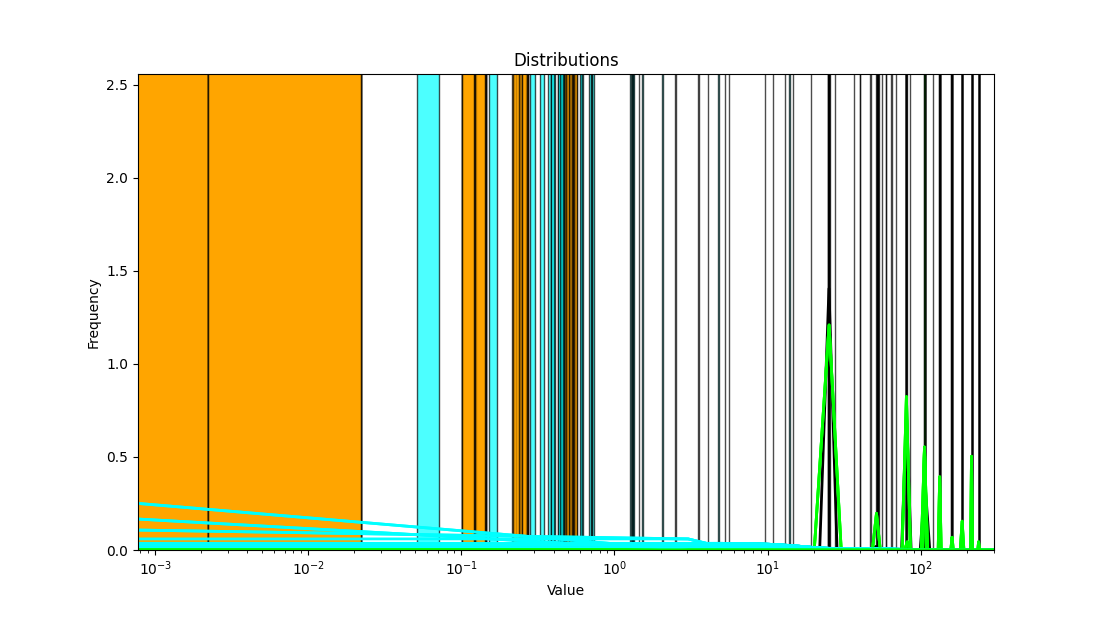

In [45]:
import numpy as np
for p in range(env.n_actions):
    if p < env.n_actions-1:
        plot_distrib(env.end_inference_delay_means[p], env.end_inference_delay_stds[p], 'cyan', p)
        transmission_delays = np.array(env.transmission_delays[env.data_sizes[p]])
        plot_distrib(transmission_delays.mean(), transmission_delays.std(), 'orange', p)
    plot_distrib(env.front_inference_delay_means[p], env.front_inference_delay_stds[p], 'lime', p)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distributions')
plt.show()